In [261]:
import numpy as np
import matplotlib.pyplot as plt
import build.pybind_modules.dsp_module as cu
import build.pybind_modules.matrix_module as myMatrix
import os
import librosa
from scipy.io import wavfile
from scipy import signal
from IPython.display import Audio

In [262]:
# Parameters used on tablet 
fs = 48000
nfft = 256
noverlap = -1
nfilt = 40
num_ceps = 13
nn_data_rows = 12
nn_data_cols = 48

In [263]:
def soundDataToFloat(SD):
    "Converts integer representation back into librosa-friendly floats, given a numpy array SD"
    return np.array([ np.float32((s)/(32768.0)) for s in SD])

In [264]:
def createButter(N, Wn, fs):
    num, den = signal.butter(N, Wn, btype='low', analog=False, output='ba', fs=fs)
    return np.array([num[i]/den[i] for i in range(len(num))])

def createFIR(num_taps, cut_off, fs):
    return signal.firwin(num_taps, cut_off, fs=fs)

def displayFIR(filt):
    coef_str = "{" 
    for val in filt: 
        coef_str += str(val) + ", " 
    coef_str = coef_str[:-2] 
    coef_str += "};" 
    print("FIR a Coefficients")
    print(coef_str) 

def applyFIR(samples, filt):
    circBuf = np.zeros(len(filt))
    circBufIdx = 0
    filteredSamples = np.zeros(len(samples))
    num_taps = len(filt)

    for i in range(len(samples)):
        circBuf[circBufIdx] = samples[i]
        curr_val = 0

        for n in range(num_taps):
            curr_val += filt[n] * circBuf[ (((circBufIdx - n) % num_taps) + num_taps) % num_taps]

        filteredSamples[i] = curr_val 
        circBufIdx = (circBufIdx + 1) % num_taps

    return filteredSamples

def trimSamples(samples, desired_num_frames, noverlap, nfft):
    if (noverlap < 0):
        noverlap = int(nfft / 2)

    step = nfft - noverlap

    return samples[:desired_num_frames*step]

In [265]:
raw_data = np.genfromtxt('Mon Apr 17 21:40:11 CDT 2023_rawsamples.csv', delimiter=',', dtype=np.int16)
my_data = np.genfromtxt('Mon Apr 17 21:40:14 CDT 2023_processed.csv', delimiter=',')
my_data = np.reshape(my_data, (12,48))
print("raw_data dtype: {}".format(raw_data.dtype))
print("my_data dtype: {}".format(my_data.dtype))


raw_data dtype: int16
my_data dtype: float64


In [266]:
Audio(raw_data, rate=fs)

Text(0.5, 1.0, 'MFCC Conducted on 48 Frames (1 Frame = 5ms)')

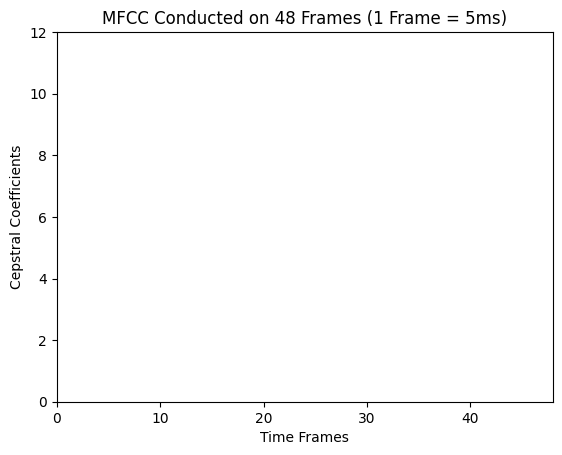

In [267]:
plt.figure()
plt.pcolormesh(my_data)
plt.xlabel("Time Frames")
plt.ylabel("Cepstral Coefficients")
plt.title("MFCC Conducted on 48 Frames (1 Frame = 5ms)")

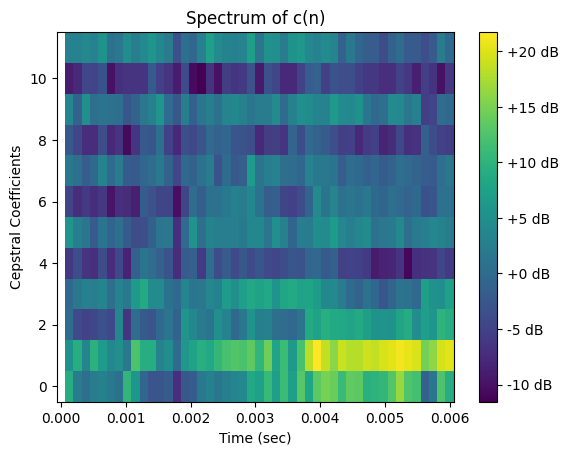

In [268]:
sig = soundDataToFloat(raw_data)

filt = createFIR(51, 3500, fs=fs)
filtered_sig = applyFIR(sig, filt)

filtered_sig = np.array([filtered_sig[i] for i in range(0, len(filtered_sig), 6)])
fs = 8000

curr_processed = np.array(myMatrix.MFCC_Matrix(list(filtered_sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:]

t_time = nn_data_cols / fs
data = np.zeros((nn_data_rows, nn_data_cols))
for row in range(nn_data_rows):
    for col in range(nn_data_cols):
        data[row,col] = curr_processed[row,col]

t = np.linspace(0, t_time, nn_data_cols)
n = np.arange(nn_data_rows)
plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, data)
plt.colorbar(format="%+2.f dB")

In [269]:
print(curr_processed)

[[            nan  9.19374511e+00  2.34777756e+00 ... -2.52502050e+02
  -2.52502050e+02 -2.52502050e+02]
 [            nan  5.23059938e+00  9.16077492e+00 ...  4.90834194e+00
   4.90834194e+00  4.90834194e+00]
 [            nan  3.10154974e-02 -4.06767940e+00 ... -2.13470247e+02
  -2.13470247e+02 -2.13470247e+02]
 ...
 [            nan  3.75627526e+00 -1.05914289e+00 ... -5.56311741e+00
  -5.56311741e+00 -5.56311741e+00]
 [            nan -8.91144513e+00 -7.90504061e+00 ... -1.79415621e+02
  -1.79415621e+02 -1.79415621e+02]
 [            nan  3.18146120e+00  3.02736112e+00 ... -6.94810236e+00
  -6.94810236e+00 -6.94810236e+00]]


In [270]:
# checking the data type from our dataset
# curr_dir = os.getcwd() + '/' + 'AudioMNIST/data'
# curr_dir = os.getcwd() + '/raw_voice_files/0_jorge/0'
# sig, fs = librosa.load(os.getcwd() + '/raw_voice_files/0_jorge/0'+'/'+'2023_03_24_16_23_23.wav', sr=8000)
# fs, sig = wavfile.read(curr_dir+'/'+'01'+'/'+'0_01_0.wav')
fs, sig = wavfile.read(os.getcwd()+'/raw_voice_files/0_jorge/0/2023_03_24_16_20_10.wav')
# sig = raw_data
print("new fs: {}".format(fs))
print("original dtype: {}".format(sig.dtype))

sig = soundDataToFloat(sig)

filt = createFIR(51, 3500, fs=fs)
filtered_sig = applyFIR(sig, filt)

filtered_sig = np.array([filtered_sig[i] for i in range(0, len(filtered_sig), 6)])
fs = 8000

num_negs = 0
print(sig)
for i in range(len(sig)):
    if sig[i] < 0:
        num_negs += 1

print("Num negs: {}".format(num_negs))
print("Data type: {}".format(sig.dtype))

new fs: 48000
original dtype: int16
[ 0.          0.          0.         ... -0.0010376  -0.00097656
 -0.00091553]
Num negs: 55216
Data type: float32


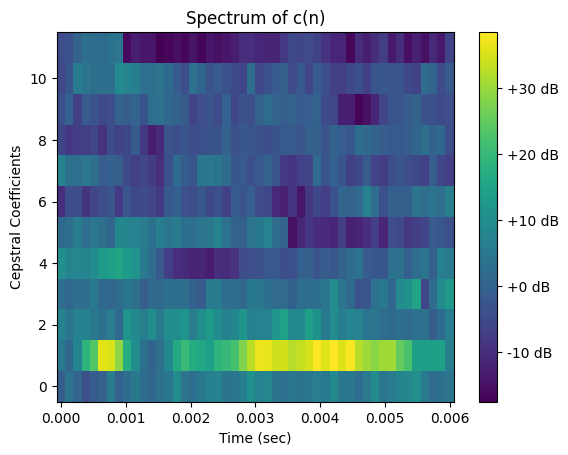

In [271]:
curr_processed = np.array(myMatrix.MFCC_Matrix(list(filtered_sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:].ravel()
t_time = nn_data_cols / fs
data = np.resize(curr_processed,(nn_data_rows, nn_data_cols))
t = np.linspace(0, t_time, nn_data_cols)
n = np.arange(nn_data_rows)
plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, data)
plt.colorbar(format="%+2.f dB")

In [272]:
# printing the FIR filter coefficients to use on the Android tablet
displayFIR(filt)

FIR a Coefficients
{-0.0009154526549517794, -0.0011114542578674472, -0.0011748111621119072, -0.0009912202839374121, -0.00040566875669237703, 0.0006928645047039383, 0.0022655744122396246, 0.004040327999447895, 0.005495567242988037, 0.005941591839728333, 0.004700288764397637, 0.0013495643820975742, -0.004031166285818187, -0.010692574509175845, -0.017194526140070547, -0.021572582846390315, -0.021684691762467997, -0.015679166273036733, -0.002483205556162394, 0.017807916482357168, 0.043749754550979104, 0.07264355863368925, 0.10091303015030824, 0.12470091418085558, 0.14056680266815558, 0.14613752935346994, 0.14056680266815555, 0.12470091418085556, 0.10091303015030822, 0.07264355863368924, 0.0437497545509791, 0.01780791648235716, -0.0024832055561623935, -0.015679166273036726, -0.021684691762467987, -0.021572582846390312, -0.017194526140070544, -0.01069257450917584, -0.004031166285818185, 0.0013495643820975731, 0.004700288764397637, 0.005941591839728333, 0.005495567242988034, 0.004040327999447